# Research Project - Brain Inspired Computing Fall 2020

Goal with this research project is to develop a spiking binary classifier for detecting between residential and industrial labeled satellite images.

Our model uses unsupervised learning, more specifically creates a decoder from the training data then uses the decoder to decode the testing data.

Google Colab Link: https://colab.research.google.com/drive/1EJoDJLQKNqixMP4WTeH14mGiwUrnpR0t#scrollTo=74kKJEmJ43eS

Link to the pitch talk which highlights our idea in more detail: https://docs.google.com/presentation/d/1TsljP_CYUNU8F0qEeb-vXzG6FSWaU5R1PI5Xx1kBa4s/edit?usp=sharing

Link to term paper: https://docs.google.com/document/d/1MOwNo2fCIBoCrqcHnFHrbyNMeSEMaRIxoSYYLZOqx7Y/edit?usp=sharing

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
np.random.seed(101)

## Satellite Dataset 

Link to the EuroSat Dataset that we used for training and testing: https://github.com/phelber/EuroSAT

Split up the satellite dataset into training, validating and testing.

~The split ratio is: 70/15/15 (training/validating/testing)~

The split ratio is: 80/20 (training/testing)

In [32]:
import os
import numpy as np
import shutil
import random

# Creating Train / Val / Test folders 
root_dir = 'Data'
classes_dir = ['/Industrial', '/Residential']

val_ratio = 0
test_ratio = 0.2

for cls in classes_dir:
    for name in ["/train", "/val", "/test"]:
        path_name = root_dir + name + cls
        if not os.path.isdir(path_name):
            os.makedirs(path_name)

    # Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print(f'Total images ({cls[1:]}):', len(allFileNames))
    print(f'Training ({cls[1:]}): ', len(train_FileNames))
    print(f'Validation ({cls[1:]}): ', len(val_FileNames))
    print(f'Testing ({cls[1:]}): ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test' + cls)

Total images (Industrial): 2500
Training (Industrial):  2000
Validation (Industrial):  0
Testing (Industrial):  500
Total images (Residential): 3000
Training (Residential):  2400
Validation (Residential):  0
Testing (Residential):  600


Images are 64 x 64 (3 Channel rgb) 64x larger than the digit images in assignment 2

Picture of Industrial Satellite Image

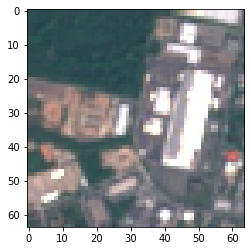

In [33]:
pic = plt.imread("Data/train/Industrial/Industrial_1.jpg")
pic.shape
plt.imshow(pic)

Picture of Residential Satellite Image

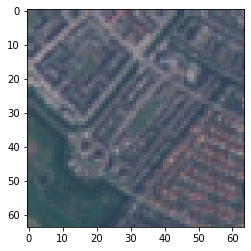

In [34]:
pic = plt.imread("Data/train/Residential/Residential_1.jpg")
pic.shape
plt.imshow(pic)

We normalize the pixel values between the values of 0 to 1, and fetch our data dividing them into the images (x_..) and their one hot encoded feature category.

In [35]:
datagen = ImageDataGenerator(rescale=1./255)

x_train_iterator = datagen.flow_from_directory('Data/train/', class_mode='categorical',shuffle=True,seed=101,target_size=(64,64), color_mode="grayscale", batch_size=5500)

x_train, one_hot_train = x_train_iterator.next()

# x_val_iterator = datagen.flow_from_directory('Data/val/', class_mode='categorical',shuffle=True,seed=101,target_size=(64,64), color_mode="grayscale", batch_size=2272)

# x_val, one_hot_val = x_val_iterator.next()

x_test_iterator = datagen.flow_from_directory('Data/test/', class_mode='categorical',shuffle=True,seed=101,target_size=(64,64), color_mode="grayscale", batch_size=2730)

x_test, one_hot_test = x_test_iterator.next()

Found 5425 images belonging to 2 classes.
Found 2492 images belonging to 2 classes.




### N.B.:

**Encoding pixel to current**

$J_M(x) = \alpha x + J^{bias}$
- $J_M$ is all past current input since *x*
- $\alpha$ is both the gain and a unit conversion factor
- $J^{bias}$ accounts for the steady background input to the cell

$J_i(x) = \alpha_i \langle x,e_i\rangle + J^{bias}_i$
- $e_i$ - random values normalised to unit length (represents the neuron's encoding or "preferred direction vector"
- $\langle\,\cdot,\cdot\rangle$ denotes the dot product between two vectors

---

**Decoding (w.o. Noise)**



$\hat{x} = Da$

$D^T \approx (A A^T)^{-1}AX^T$

```
"""
Decoder Python Code
d : Dimensionality of the value represented by a neuron population
n : Number of neurons in a neuron population
N : Number of samples
"""
A = np.array(...) # n x N array
X = np.array(...) # d x N array
D = np.linal.lstsq(A.T, X.T)[0].T
```
More Info: [Moore-Penrose Inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse)

**Decoding (w. Noise)**
> Biological neural systems are subject to significant amounts of noise from various sources. Any analysis of such systems must take the effects of noise into account.

The idea to introduce noise into our model is by applying regularisation factors to the decoder.

$D^T \approx (A A^T + N \sigma^2 I)^{-1} A X^T$, where $I$ is the $n$ $x$ $n$ identity matrix

```
"""
Decoder Python Code
"""
A = np.array(...) # n x N array
X = np.array(...) # d x N array
D = np.linal.lstsq(A @ A.T + 0.5 * N * np.square(sigma) * np.eye(n), A @ X.T)[0].T
```

---

**Computer Firing Rate from Current**


- $a(x)$ is the firing rate at time x
- $\tau^{ref}$ refractory period time constant
- $\tau^{RC} $ Membrane time constant (aka the characteristic time or relaxation time)
- $J_{th}$ threshold current

- $a(x) = \frac{1}{\tau^{ref} - \tau^{RC}ln(1-\frac{J_{th}}{J_M(x)})}$
- assume $J_{th}$ = 1

$$
G(J) = \begin{cases} 
      a(x) = \frac{1}{\tau^{ref} - \tau^{RC}ln(1-\frac{1}{J_M(x)})} & \text{if }{J_M(x)} > 1 \\
      0 & \text{otherwise}
\end{cases}
$$


Resources: 
1. http://compneuro.uwaterloo.ca/courses/syde-750.html


#### Constants

In [43]:
input_size = 4096 # 64 x 64 images
hidden_size = 8 # number of neurons in hidden layer

# first and second one are for calculating firing rate
# third on used in the PSC Filter
t_ref = 0.002 #2ms
t_rc = 0.02 #20ms
t_psc = 0.05 #50ms

**Post-synaptic Current Filter**

use case is to filter the spike train from the LIF neuron

$
h(t) = \begin{cases} 
      c^{-1} t^n e^{-\frac{t}{\tau}} & \text{if }{t} \ge 0 \\
      0 & \text{otherwise}
\end{cases}
$
*where n is a non-negative integer, and c normalizes the filter to area one to preserve energy*

$c = \int_{0}^\infty t^n e^{-\frac{t}{\tau}} dt$

In [44]:
def PSC_filter(Tsim, dt):
    """
    Temporal Decoder to decode the spike trains during LIF neuron simulation
    """
    t = np.linspace(0,Tsim,int(np.round(Tsim/dt)))
    h = np.exp(-(t-Tsim/2)/t_psc)
    h[0:len(h)//2] = 0
    h = (1/dt)*h/np.sum(h)
    return h

def sample_spherical(npoints): #sample a vector of dimension "ndim" from the unit sphere randomly
    """
    Returns a ndim unit vector sample
    """
    vec = np.random.randn(npoints)
    vec /= np.linalg.norm(vec)
    return vec

## Training

In [45]:
"""
Training 
"""

alpha_vec = np.zeros(hidden_size)
J_bias_vec = np.zeros(hidden_size)
e_vec = np.zeros((hidden_size, input_size))
num_input = len(x_train)

def train():
    A_train = np.zeros((num_input, hidden_size))
    for i in range(hidden_size):

        #Encoding
        amax = np.random.uniform(100, 200)  # maximum firing rates randomly chosen (uniformly distributed between 100Hz and 200Hz at x=1)
        xi = np.random.uniform(-0.95, 0.95) # x-intercepts uniformly distributed between -0.95 and 0.95

        alpha = (1/(1-np.exp((t_ref - 1/amax)/t_rc)) - 1)/(1-xi) #slope=(y2-y1)/(x2-x1)
        J_bias = 1 - xi * alpha #y-intercept (assume e in this case to be 1)

        e = sample_spherical(input_size)

        alpha_vec[i] = alpha
        J_bias_vec[i] = J_bias
        e_vec[i] = e

        a_x = np.zeros(num_input)

        for j in range(num_input):
            J_M = np.multiply(alpha, np.inner(e, x_train[j].reshape(input_size))) + J_bias
            if J_M > 1:
                a_x[j] = 1/(t_ref - t_rc*np.log(1- 1/J_M))

        A_train[:,i] = a_x


    #Add Noise to replicate biological phenomenal
    mu, sigma = 0, 0.01*np.max(A_train) # mean and standard deviation
    s = np.random.normal(mu, sigma, A_train.shape)
    A_noisy = np.add(A_train, s) 

    global decoder
    decoder = np.linalg.lstsq(
        A_train.T @ A_train + 0.5 * num_input * np.square(sigma) * np.eye(hidden_size), A_train.T @ one_hot_train
    , rcond=None)[0]

    x_hat = np.dot(A_noisy, decoder)
#     MSE = np.mean(np.power(one_hot_train-x_hat, 2))

#### Testing


**LIF Equation**

$ \frac{dv}{dt} = \frac{1}{\tau_{rc}}(J-V)$

Using Euler's Method

$V_{t+1} = V_{t} + dt * \frac{dv}{dt}$


In [36]:
"""
Simulating LIF Neuron
"""

def simulate_neuron(Tsim, dt, t_rc, t_ref, vrest, vth, J):
    N = int(np.round(Tsim/dt))
    Vprev = 0
    Jprev = 0
    spike_train = np.zeros(N)
    mutex = 0  
    
    for i in range(N):
        if mutex == 0: #mutex indicates the refractory period
            dvdt = 1/(t_rc) * (J[i] - Vprev)
            V = Vprev + dt * dvdt
            if V < vrest:
                V = vrest
            elif V > vth:
                spike_train[i] = 1
                V = vrest
                mutex = np.round(t_ref/dt)
            Jprev = J[i]
            Vprev = V
        else:
            mutex -= 1
    return spike_train


In [46]:
"""
Testing
"""
def test():
    num_input = len(x_test)

    Tsim = 0.1
    dt = 0.001
    v_rest = 0
    v_th = 1
    Tlen = int(np.round(Tsim/dt))
    
    A_test = np.zeros((num_input, Tlen, hidden_size))
    h = PSC_filter(Tsim, dt)
    t = np.linspace(0, Tsim, Tlen)
    print(h)
    for i, (alpha, J_bias, e) in enumerate(zip(alpha_vec, J_bias_vec, e_vec)):
        a_x = np.zeros((num_input, Tlen))
        
        for j in range(num_input):
            J_M = np.multiply(alpha, np.inner(e, x_test[j].reshape(input_size))) + J_bias
            Jin = J_M*np.ones(Tlen)

            spike_train = simulate_neuron(Tsim, dt, t_rc, t_ref, v_rest, v_th, Jin) #Only Jin changes on different function call
            a_x[j] = np.convolve(spike_train, h, 'same')
            
        A_test[:,:,i] = a_x

    
    accuracy_history = np.zeros(Tlen)
    for t_i in range(Tlen):
        x_hat_test = np.dot(A_test[:,t_i,:], decoder) #decode activity of the population
        cnt = sum(1 for i in range(num_input) if np.argmax(x_hat_test[i]) != np.argmax(one_hot_test[i]))#count error rate of model    
        accuracy_rate = 100 - 100*cnt/num_input #compute error rate of model
        accuracy_history[t_i] = accuracy_rate

    """
    Accuracy over time
    """ 
    plt.figure(figsize=(20,10))
    plt.plot(t, accuracy_history, '.-')
    plt.title(f'Accuracy of model in function of time')
    plt.xlabel('Time [s]')
    plt.ylabel('Accuracy on test set [%]')
    plt.grid('on')
    plt.show()
    
    print(f"Testing: Error: {np.round(100 - accuracy_history[-1])}")

#### Testing (NO LONGER USING)

In [47]:
def run():
    train()
    test()
#     val()

### Results

Neurons | Testing Error:
4 - 33%
8 - 29%
16 - 27%
32 - 26%
64 - 21%
128 - 17%

References:

- Ali Safa. (2020, July 19). Digit Classification Using a One-Hidden-Layer Spiking Neural Network (Version V1.3). Zenodo. http://doi.org/10.5281/zenodo.3951585
- Eliasmith, Chris, and Charles H. Anderson. Neural Engineering: Computation, Representation, and Dynamics in Neurobiological Systems. Mitt Press, 2003. 
- Eric Hunsberger, Chris Eliasmith: “Spiking Deep Networks with LIF Neurons”, 2015; <a href='http://arxiv.org/abs/1510.08829'>arXiv:1510.08829</a>.
- Runchun Wang, Chetan Singh Thakur, Tara Julia Hamilton, Jonathan Tapson, Andre van Schaik: “A neuromorphic hardware architecture using the Neural Engineering Framework for pattern recognition”, 2015; <a href='http://arxiv.org/abs/1507.05695'>arXiv:1507.05695</a>.
- J. Dethier, V. Gilja, P. Nuyujukian, S. A. Elassaad, K. V. Shenoy, & K. Boahen (2011). Spiking neural network decoder for brain-machine interfaces. In 2011 5th International IEEE/EMBS Conference on Neural Engineering (pp. 396-399).
- Terrence C. Stewart. A technical overview of the neural engineering framework. Technical Report, Centre for Theoretical Neuroscience, 2012.
- Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
- Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

